# Optimizing MS2 corrections with 120-mer data

I want to use 120-mer data to optimize corrections for bleaching and depth. I took two kinds of data: large stacks at distinct laser powers, and some simulated MS2 movies to test for both correction types.

## Conclusions

### Depth correction

After some significant adventures, I think I have finally concluded that the depth correction is essentially linear with a near-constant slope in the relevant intensity and depth ranges. I worked out a more complicated solution using exponential fits to the intensity-depth data, but I think it's actually just overkill. The strategy going forward will be to collect standard candle data to match the imaging conditions of relevant datasets, verify linearity and get the correction slope of these data, and just use linear correction. It's simple and effective.

##### Update

This was an error caused by a bug in my code below! They are in fact still curved, and I returned to trying to do exponential fits, or at least considering it.

### Bleaching correction

A similar answer for bleaching correction. I found that using the frame mean intensity to do correction does an excellent job of keeping the 120-mer intensity constant. It's possible that real data will be a bit different, e.g., if the section of nucleus covered changes, or if HLBs drift in or out of focus. But good datasets should be pretty consistent, and I think we can assume that's not a huge issue for the moment.

In [177]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage as ndi 
from importlib import reload
import pickle
import czifile
from skimage.filters.thresholding import threshold_otsu

# The order of loading matplotlib is important to avoid issues on my machine.
%matplotlib inline
import matplotlib as mpl
#%matplotlib notebook
#%matplotlib notebook

# Import my packages.
import flymovie as fm

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Depth

### Process 120mer stacks

Need to find a way to detect spots in a way that isn't biased in Z, i.e. that doesn't select for brighter spots in higher Z slices. One way (partly) around that is to normalize the slices. This analysis will only be as good as the quality of detection, so it's definitely important.

In [323]:
# Read file.
czi_filename = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/quantitation/20210524-120mer-deepstack-em2-1p5pct-01.czi'
stack, first_dist, z_interval = fm.load_save.read_czi(czi_filename, swapaxes=True, trim=True, return_metadata=True)
fm.viewer(stack, 12)

interactive(children=(Dropdown(description='Color', index=2, options=('prism', 'gray', 'cividis', 'Gators', 'm…

### Normalizing Z slices

I need to normalize intensities in the Z slices to avoid biases in spot detection. The easiest approach is to use the mean (or median) values of the slices. This works *ok* but I want to see if I can do better. One idea is to try to make the histograms for the slices match in some way. I don't want to mess with anything non-linear right now: just find factors to multiply the slices by.

My idea to start:
- Pick a reference slice, take its histogram (probably chopping the tails to avoid outliers)
- For each slice, take the histogram, do some optimizing to find the multiplier that minimizes the difference between the histograms.
- That's it

In [185]:
from scipy import optimize
def zstack_normalize_histogram(stack3d):
    def get_histogram(slice_):
        outlier_cutoff = np.percentile(slice_, 99.9)
        bg_cutoff = np.percentile(slice_, 0)
        vals = slice_.flatten()
        vals_trimmed = vals[(vals >= bg_cutoff) & (vals <= outlier_cutoff)]
        counts, bins = np.histogram(vals_trimmed, bins=200, range=(0,20000))
        return counts

    stack = stack3d.copy()
    ref_slice = stack[int(stack.shape[0] / 2)]
    ref_histogram = get_histogram(ref_slice)

    for z in range(0, stack.shape[0]):
        #slice_histogram = get_histogram(stack[z])
        slice_ = stack[z]
        def errorfunction(m):
            slice_histogram = get_histogram(m * slice_) 
            sq_err = np.square(ref_histogram - slice_histogram)
            return np.nansum(sq_err)
            #err = ref_histogram - slice_histogram
            #err[np.isnan(err)] = 0
            #return err

        opt = optimize.minimize_scalar(errorfunction)
        #opt = optimize.least_squares(errorfunction, m)
        print(opt.x)
#zstack_normalize_histogram(stack[0,0])

In [186]:
#np.mean(stack[0,0], axis=(1,2))

So this seems to work as intended, but it has the same problem as the mean-based approach, where the inferred slice intensity decreases with depth for a while then levels out and even climbs a bit. I think this is probably from schmutz encountered deeper in the embryo throwing things off, but it certainly means the correction isn't working, as spot intensity decreases monotonically with depth (as it must). How about back up and using an operational approach? I'm trying to solve the problem of the number of detected spots decreasing with depth, so how about just choosing adaptive thresholds that keep the number of detected spots constant? There's no guarantee that the *true* number of spots is invariant in Z, but perhaps over a limited range we can assume this. 

A very simple solution: build a threshold slope factor into the thresholding, let the use adjust it until the relationship of detected spots and z slice looks acceptable.

In [324]:
# Perform DoG filtering.
channel=0
sigma_big = 4
sigma_small = 0

# Normalize Z slices and make stacks.
stack3d = stack[channel, 0]
stack4d = np.expand_dims(stack3d, axis=0)
stack5d = np.expand_dims(stack4d, axis=0)

dog = fm.dog_filter(stack3d, [0,sigma_small,sigma_small],[0,sigma_big,sigma_big])

In [42]:
# Set a threshold for defining putative spots.
t = 1000
fm.viewer(dog, 8, color='cividis', init_minval=t, init_maxval=t+1)
plt.plot

interactive(children=(Dropdown(description='Color', index=2, options=('prism', 'gray', 'cividis', 'Gators', 'm…

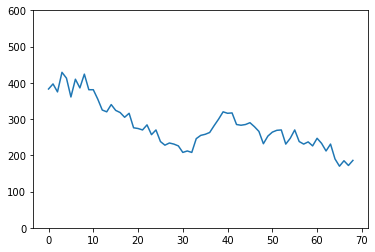

In [326]:
def threshold_w_slope(stack, ref_thresh, ref_slice, slope, display=False):
    mask = np.zeros_like(stack)
    n_slices = stack.shape[0]
    thresh_start = ref_thresh - (ref_slice * slope)
    thresh_end = ref_thresh + ((n_slices - ref_slice - 1) * slope)
    thresh = np.linspace(thresh_start, thresh_end, n_slices)
    
    for z in range(0, n_slices):
        mask[z] = np.where(stack[z] > thresh[z], 1, 0)
    mask = ndi.morphology.binary_opening(mask, np.ones((1,2,2)))

    if display:
        counts = []
        for z in range(0, n_slices):
            _, count = ndi.label(mask[z])
            counts.append(count)
        plt.plot(counts)
        plt.ylim(0,600)
    return np.expand_dims(mask, axis=0)

mask = threshold_w_slope(dog, 3500, 30,-30, display=True)
#fm.viewer(a, 8)

This seems pretty reasonable, at least. Let's see how it goes.

In [319]:
fm.viewer(mask,8)

interactive(children=(Dropdown(description='Color', index=2, options=('prism', 'gray', 'cividis', 'Gators', 'm…

In [327]:
# Perform 3D gaussian fitting on each object in the binary mask.
fits = fm.fit_objects_from_mask(stack4d, mask, fitwindow_rad_z=1, fitwindow_rad_xy=3)
fm.quickview_ms2(stack5d, fits, MAX=False, shadows=False, halfwidth_z=0)

0
# to fit: 13449
# fit:  1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 

interactive(children=(Dropdown(description='Color', index=2, options=('prism', 'gray', 'cividis', 'Gators', 'm…

#### Testing fit filtering

Want to try some different filtering parameters and see how this goes.

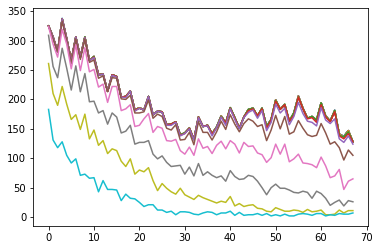

In [329]:
# Plot spots detected per Z slice at different filtering peakiness thresholds.

def count_spots_byz(stack):
    counts = []
    for z in stack:
        counts.append(z.shape[0])
    return counts

for p in np.arange(0, 10, 0.5):
    # Filter spots based on fit parameters, view results.
    peakiness = p
    fits_filtered = fm.filter_ms2fits(fits, peakiness, stack)
    #fm.quickview_ms2(stack5d, fits_filtered, MAX=False, shadows=False, halfwidth_z=0)
    # Get spot-centered stacks, organized by z slice.
    spots_byz = fm.spotstacks_fromfits_byz(stack4d, fits_filtered)
    counts = count_spots_byz(spots_byz)
    plt.plot(counts)

Hmm, so first of all we see a significant decrease in detected spots with increasing Z at all thresholds. Second, the filtering doesn't seem to do much of anything until we hit 7 (light purple), and peaks at about 9.5. I think I'll try using 7 since it seems to just trim a few candidate spots off, which seems right visually as most of the spots look fine to me.

In [330]:
# Filter spots based on fit parameters, view results.
peakiness = 7
fits_filtered = fm.filter_ms2fits(fits, peakiness, stack)
#fm.quickview_ms2(stack5d, fits_filtered, MAX=False, shadows=False, halfwidth_z=0)
# Get spot-centered stacks, organized by z slice.
spots_byz = fm.spotstacks_fromfits_byz(stack4d, fits_filtered)

In [306]:
fm.viewer(spots_byz[30], 5)

interactive(children=(Dropdown(description='Color', index=2, options=('prism', 'gray', 'cividis', 'Gators', 'm…

In [331]:
# Save results.
fm.save_pickle([spots_byz.copy(), fits, first_dist, z_interval],'/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210524-120mer-deepstack-em2-1p5pct-02.pkl')
spots_em2_1p5 = spots_byz.copy()
print(first_dist)

-0.00062847


### Compute depth correction

In [ ]:
datasets = [spots_em1_0p5, spots_em1_1p0, spots_em1_1p5, spots_em1_2p0, spots_em2_0p5, spots_em2_1p0, spots_em2_1p5, spots_em2_2p0]
surface = [-626, -625.62, -625.62, -624.48, -631.92, -631.92, -633.05, -632.64]
starts = [-623.7, -623.7, -623.7, -618.9, -628, -628, -628, -628]

interval = float(0.23)

In [332]:
datasets = [spots_em2_0p5, spots_em2_1p0, spots_em2_1p5]
surface = [-631.92, -631.92, -633.05]
starts = [-628, -628, -628]

interval = float(0.23)

In [ ]:
datasets = [spots_em2_0p5, spots_em2_1p0, spots_em2_1p5]
surface = [-631.92, -631.92, -633.05]
starts = [-628, -628, -628]

interval = float(0.23)

depths, intensities = fm.make_depth_vs_intensity_vectors(datasets, surface, starts, interval, 
        return_mean=True, min_spots_for_mean=10, mode='mean_intensity', inner_length_ij=3)

for n in range(0,3):
    plt.scatter(depths[n], intensities[n])

In [335]:
depths, intensities = fm.make_depth_vs_intensity_vectors(datasets, surface, starts, interval, 
        return_mean=True, min_spots_for_mean=10, mode='mean_intensity', inner_length_ij=3)

In [336]:
# Add dummy dataset until I can get a weaker one.
depths = [depths[0]] + depths
intensities = [intensities[0] - 3500] + intensities

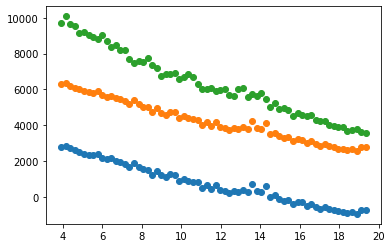

In [338]:
for n in range(0,4):
    plt.scatter(depths[n], intensities[n])

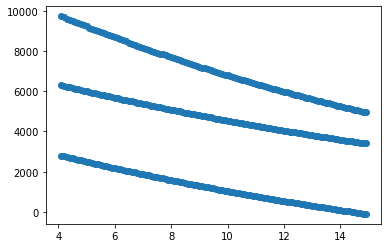

In [341]:
good_datasets = [0,1,2]
xgrid_start = 0
xgrid_end = 25
xgrid_incr = 0.1
ygrid_start = 0
ygrid_end = 20000
ygrid_incr = 100

depths_good = [depths[n] for n in good_datasets]
intensities_good = [intensities[n] for n in good_datasets]
paramgrid_a, paramgrid_b, paramgrid_c = fm.fit_interpolate_depth_curves(depths_good, intensities_good, xgrid_start, 
    xgrid_end, xgrid_incr, ygrid_start, ygrid_end, ygrid_incr, display=True) 

                                     

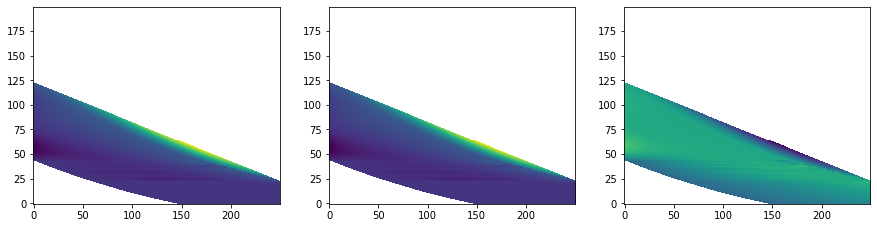

In [342]:
plt.figure(figsize=(15,80))
plt.subplot(131)
plt.imshow(np.swapaxes(paramgrid_a,0,1), origin='lower')
plt.subplot(132)
plt.imshow(np.swapaxes(paramgrid_b,0,1), origin='lower')
plt.subplot(133)
plt.imshow(np.swapaxes(paramgrid_c,0,1), origin='lower');

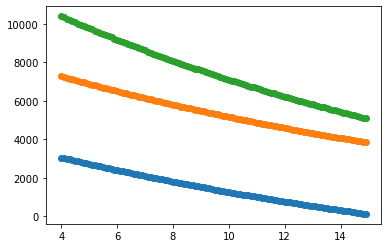

In [351]:
test_pts = [(80,19),(100,50),(100,70)]

for pt in test_pts:
    x = np.arange(4,15,0.1)
    a = paramgrid_a[pt]
    b = paramgrid_b[pt]
    c = paramgrid_c[pt]
    y = a * np.exp(-b * x) + c
    plt.scatter(x,y)

### Conclusions about new spot detection methods:

I think this was largely successful. Being able to get more uniform spot detection (wrt Z) certainly comforts me. The biggest change is that the shapes of the curves has become much less exponential and nearly linear. Was the curve an artefact of spot-detection bias? Seems likely. Makes me glad I corrected it. It's probably fine to now model these as linear functions, and indeed the slope doesn't even seem to change very much. In light of this data, it makes more sense that the linear corrections I was applying to MS2 data appeared to be fairly reasonable. 

Still, I'll stick with the exponential fits for now, if for no other reason than that I wrote this code and it's pretty cool! Also, it should be more extensible. 


### Some thoughts on issues:

- We only have GFP. These effects likely differ based on wavelength. Hopefully GFP gives us reasonable estimates. Can you make mCherry nanocages?


- Using laser power to achieve differential brightness. The effect of depth will come from decreased excitation and emission (light traveling both ways through sample), and it's a little hard to figure how this will work. What we really want is to have emitters of various brightnesses under constant laser power, which is presumably coming with the alternate sized nanocages. In the meantime, I think we live with this. The similarity of the curves suggests it's *probably* ok.  


- Calculating object intensity. The nanocages are much smaller than MS2 spots. We can't quantify their intensity using the same-sized box for calculating intensity mean, since a box that fits the nanocages will be too small for the MS2 spots, and a box (or ellipsoid) for the MS2 spots will be too large for the nanocages, bringing in lots of background pixels and lowering the mean. This likely isn't a perfectly surmountable problem, and we should expect some mis-mapping of intensities. Luckily the differences in exponential shape aren't particularly large, so a reasonable equivalency between the two measures should be enough to get us a decent correction. This isn't going to be perfect, anyway. 

 
- Bias in spot detection. Spot detection in the 120-mer stacks will be somewhat biased by intensity: you'll detect more faint spots in the brighter slices and select for the brighter spots in the dimmer slices. This would be expected to lead to under-correction. Better spot detection algorithms could account for this, but it also may not be perfectable. I also wonder about not using the mean as the metric... I tried the median and it doesn't look much better, just a little noisier.  

An alternative experimental approach that could have some merit is injected fluorescent bead standards. I ordered some 0.1 µm diameter "tetraspeck" beads from Fisher. They are coated in blue, green, orange, and far red dyes, and are supposed to be fairly uniform. The experiment would be to inject these, image in both green and red channels (the orange is close-ish to mCherry), perform the calibrations in this notebook, and just see how green and red compare. If they're similar, we are good. If not, we may have to use separate calibrations for green and red.


### Thoughts end of May:

Looking and thinking carefully about this, doing the correction perfectly this way will be very hard. It may not be doable at all. Then again, it's a reasonable concept, and the conclusion seems to be that intensity decays with depth with a fairly predictable shape. This should give at least a reasonable correction for depth effects, and provides a framework for future refinement with all kinds of new measurements. It seems to be the correct way to ultimately go.

That being said, an obvious alternative is to correct 'from the data', to just factor out Z effects from the MS2 intensity measurements. Basically, measure the sample depth for each spot, determine the relationship between sample depth and spot intensity, and normalize so that the association is flat. One issue here is that it involves making the assumption that spot intensity doesn't vary as a function of nuclear position (biologically dubiout). A second issue is the potential for confounding effects, e.g. spots simultaneously weaken (due to biology and bleaching) and drift deeper into sample with time, leading to an overcorrection. The best way to do this would be to choose some shared time (say middle nc14 with robust spot expression) and internally normalize within each frame to account for bleaching. Anyway, this is a good strategy.


### Thoughts early June:

I'm thinking this may be overdone. The challenge of comparing object intensities is a real one. I think a much simpler strategy, based on these recent data with Z-corrected object detection, may be the following:

- For a given MS2 dataset, take image stacks of 120-mers using matched imaging conditions but varying laser power (later: use 60-mers, etc.).
- Process depth vs. intensity for these datasets, verify that curves are approximately linear in the range of depths at which MS2 spots are found.
- Get slope off of data, apply correction, test on data.


# Bleaching correction

Here's my basic plan:

1. Apply correction to spots
2. Detect spots in a few frames (spaced out)
3. Plot intensity vs. Z for frames

Starting with the *pseudo-MS2* movie em3-01 taken on 5/24. The embryos surface was recorded:

Before movie: -624.55 µm  
After movie: -622.86 µm


In [ ]:
def segment_nanocages(stack):
    
    sigma_big = 4
    sigma_small = 0

    # Make stacks.
    #stack5d = np.expand_dims(stack4d, axis=0)
    frames = []
    for t in range(0, stack.shape[0]):
        stack3d = stack[t]
        stack4d = np.expand_dims(stack3d, axis=0)
        # Perform DoG filtering.
        dog = imp.dog_filter(stack3d, [0,sigma_small,sigma_small],[0,sigma_big,sigma_big])

        t = 1500

        # Make a binary mask from threshold.
        mask = np.where(dog >= t, 1, 0)
        mask = ndi.morphology.binary_opening(mask, np.ones((1,2,2)))
        mask = np.expand_dims(mask, 0)
        # Perform 3D gaussian fitting on each object in the binary mask.
        fits = imp.fit_objects_from_mask(stack4d, mask, fitwindow_rad_z=1, fitwindow_rad_xy=3)
        # Filter spots based on fit parameters, view results.
        peakiness = 5
        fits_filtered = imp.filter_ms2fits(fits, peakiness, stack)
        # Get spot-centered stacks, organized by z slice.
        spots_byz = imp.spotstacks_fromfits_byz(stack4d, fits_filtered)
        frames.append(spots_byz)
    return frames
        

In [426]:
def segment_nanocages2(stack3d, thresh_init=1500, ref_slice=30, slope=-30):
    # Perform DoG filtering.
    channel=0
    sigma_big = 4
    sigma_small = 0

    # Normalize Z slices and make stacks.
    stack4d = np.expand_dims(stack3d, axis=0)
    stack5d = np.expand_dims(stack4d, axis=0)

    dog = fm.dog_filter(stack3d, [0,sigma_small,sigma_small],[0,sigma_big,sigma_big])

    mask = threshold_w_slope(dog, thresh_init, ref_slice, slope, display=True)

    fits = fm.fit_objects_from_mask(stack4d, mask, fitwindow_rad_z=1, fitwindow_rad_xy=3)

    # Filter spots based on fit parameters, view results.
    peakiness = 7
    fits_filtered = fm.filter_ms2fits(fits, peakiness, stack)

    # Get spot-centered stacks, organized by z slice.
    spots_byz = fm.spotstacks_fromfits_byz(stack4d, fits_filtered)

    return spots_byz

def plot_depths_intensities(datasets, surface, starts, interval):
    depths, intensities = fm.make_depth_vs_intensity_vectors(datasets, surface, starts, interval, 
            return_mean=True, min_spots_for_mean=10, mode='mean_intensity', inner_length_ij=3)

    for n in range(0,len(datasets)):
        plt.scatter(depths[n], intensities[n])

In [ ]:
czi_filename = '/Volumes/Stadler100/2021-05-24/20210524-120mer-pseudoms2-em3-01.czi'
stack, first_dist, z_interval = fm.read_czi(czi_filename, swapaxes=True, trim=True, return_metadata=True)
fm.viewer(stack)

#### Uncorrected first

To fit:  
0: 7477  
15: 6233  
30: 5541  
40: 5288

0
# to fit: 5288
# fit:  1000 2000 3000 4000 5000 

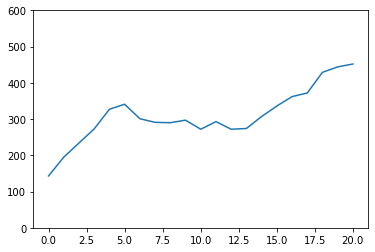

In [432]:
uncorr_f40 = segment_nanocages2(stack[0,40], 1500, 10)

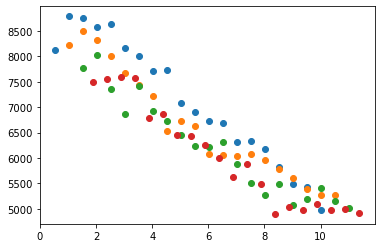

In [433]:
datasets = [uncorr_f0, uncorr_f15, uncorr_f30, uncorr_f40]
-624.55
surface = [-622.86, -623.36, -623.86, -624.21]
#surface = [-622.86, -622.86, -622.86]
starts = [-622.33, -622.33, -622.33, -622.33]

interval = float(0.5)

plot_depths_intensities(datasets, surface, starts, interval)

Next, let's try the frame mean approach.

In [395]:
def bleach_correct_framemean(stack4d):    
    stack_corr = stack4d.copy()
    means = np.mean(stack4d, axis=(1,2,3))
    grand_mean = np.mean(stack4d)
    for t in range(0, stack4d.shape[0]):
        stack_corr[t] = stack4d[t] / means[t] * grand_mean
    return stack_corr, means

In [434]:
stack_bcfm, means = bleach_correct_framemean(stack[0])

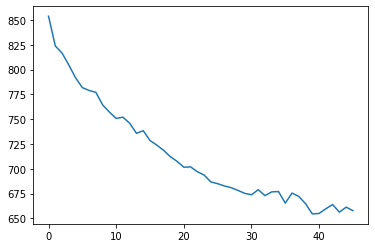

In [436]:
plt.plot(means)

To fit:  
0: 6624  
15: 6147  
30: 5778

0
# to fit: 5778
# fit:  1000 2000 3000 4000 5000 

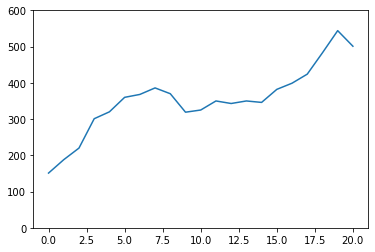

In [440]:
fmcorr_f30 = segment_nanocages2(stack_bcfm[30], 1500, 10)

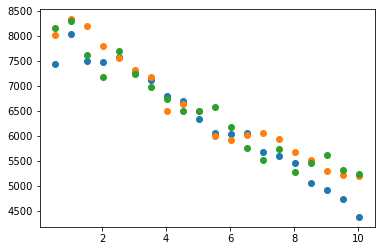

In [442]:
datasets = [fmcorr_f0, fmcorr_f15, fmcorr_f30]
-624.55
#surface = [-622.86, -623.36, -623.86, -624.21]
surface = [-622.86, -622.86, -622.86]
starts = [-622.33, -622.33, -622.33, -622.33]

interval = float(0.5)

plot_depths_intensities(datasets, surface, starts, interval)

Wow. That seems to just...work. I can revisit this later if needed, but shit, if the simplest solution works...